# Exercise 2: Decision Trees

# Part 1: Theoretical Exercises (16 points)


## 1. Gini Impurity
In class, we defined the Gini impurity as 
$$
\varphi_{Gini}(p) = 1 - \sum_{j=1}^k p_j^2,\qquad p \in [0,1]^k~,
$$
where $p=(p_1,\ldots,p_k)$ represents class proportions in a set of instances. This means that $\sum_{j=1}^kp_j = 1$. 

1. Prove that 
$$
\varphi_{Gini}(p) \leq 1-1/k.
$$
Hint: 
- Express the function $f : \mathbb R^{k-1} \to \mathbb R$:
$$
f(p_1,\ldots,p_{k-1}) = \varphi_{Gini}(p_1,\ldots,1 - \sum_{j=1}^k). 
$$
- Argue that $f$ is bounded from above, hence it has a maximal value in $\mathbb R^{k-1}$. 
- Solve the equation $\nabla f = 0$ and argue that the solution is unique. 

(you do not have to follow the hint; all correct and clearly written solutions are acceptable)


Let $Y_1$ and $Y_2$ be two independent random variables, each represnting the class label of a randomly sampled instance from the set. Namely:
$$
 \Pr[Y_i = j]=p_j, \qquad i\in\{1,2\}, \qquad j\in\{1\ldots k\}~.
$$ 
2. Prove that Gini impurity is the probability that two randomly sampled instances (with replacement) from the set of instances have different class labels. Namley, that
$$
\varphi_{Gini}(p) = \Pr[Y_1 \neq  Y_2].
$$



## 2. Information Gain
In class we claimed that **information gain is always non-negative**. Here, we will prove this for the specific case of binary classification, where we have only two class labels.

Recall that information gain is defined as follows:
$$
IG(S,A) ~~=~~ H(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}H(S_v)~,
$$
where $S$ is a set of data instances, $A$ is an attribute (ferature) with a finite set of possible values $Values(A)$, and $H$ is the entropy function applied to the probability vector associated with the class frequencies. Assuming that there are only two class lables, the entropy can be expressed as follows:
$$
H(S)  ~~=~~ h(p_1) ~~=~~ -p_1\log(p_1)-(1-p_1)\log(1-p_1)~,
$$
where $p_1$ is the frequency of the first label (and $1-p_1$ is the frequency of the second label). Here, we adhere to the convention that $0\cdot \log(0) = 0$ (as $\log(0)$ is undefined). 

We start by examining the function $h()$, which is also called the *binary entropy function* (see plot below). One feature of this function is that it is *concave*. Concave functions satisfy the following property: for every $x_1,x_2\in[0,1]$ and for every $\lambda_1,\lambda_2\in[0,1]$ such that $\lambda_1+\lambda_2=1$, we have:
$$
\begin{align}
h(\lambda_1 x_1 +  \lambda_2 x_2) \geq \lambda_1 h(x_1) + \lambda_2 h(x_2). 
\end{align}
$$

The plot below illustrates this inequality, whose correctness we will assume here without a formal proof (this can be proved by analysis of the first and second derivatives of $h()$).
![Entropy-concave](entropy-concave.png)

1. Use the inequality in (1) to prove (by induction) a more general claim: for any $t\geq 2$ points $x_1\ldots x_t\in [0,1]$, and $t$ weights $\lambda_1\ldots \lambda_t\in [0,1]$ such that $\sum_{j=1}^t\lambda_j = 1$, we have
$$
h\left(\sum_{j=1}^t\lambda_jx_j\right) \geq \sum_{j=1}^t\lambda_jh(x_j)~.
$$
This inequality, which applies to all concave functions, is also called *Jensen's inequality*.

2. Use the inequality you proved above to prove that information gain is always non-negative (when there are only two classes).

# Part 2: Coding Assignment (84 points)

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in other object oriented programming languages you might be familiar with. You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [23]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [24]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x16809d310>, <__main__.Node at 0x1678f6210>]

## 2. Data Exploration and Preprocessing

### Data Exploration
For the following exercise, we will use a dataset containing information on mushrooms. This dataset includes descriptions of hypothetical samples from 23 species of gilled mushrooms in the Agaricus and Lepiota genera. Each sample is identified as being "definitely edible", "definitely poisonous", or of "unknown edibility". Here, we will be conservative and will group the species of "unknown edibility" with the poisonous ones. Thus, we will have two classes: **edible** and **poisonous**. 
    
Each sample is also provided with information on the following 21 attributes (features):
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
1. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
1. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
1. bruises: bruises=t,no=f
1. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
1. gill-attachment: attached=a,descending=d,free=f,notched=n
1. gill-spacing: close=c,crowded=w,distant=d
1. gill-size: broad=b,narrow=n
1. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
1. stalk-shape: enlarging=e,tapering=t
1. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
1. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
1. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
1. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
1. veil-type: partial=p,universal=u
1. veil-color: brown=n,orange=o,white=w,yellow=y
1. ring-number: none=n,one=o,two=t
1. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
1. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
1. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
1. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

The table in `agaricus-lepiota.csv` contains feature and class information on 8124 mushroom samples. We start by reading the data using the `.read_csv` method from ``pandas``, and then visually the top and bottom of the table.

In [25]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')
data

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,o,o,p,o,o,p,b,c,l,e
8120,x,s,n,f,n,a,c,b,y,e,...,o,o,p,n,o,p,b,v,l,e
8121,f,s,n,f,n,a,c,b,n,e,...,o,o,p,o,o,p,b,c,l,e
8122,k,y,n,f,y,f,c,n,b,t,...,w,w,p,w,o,e,w,v,l,p


One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always important. Use the following command to confirm that there are no missing values in the data table.

In [26]:
data = data.dropna(axis=1)

### Train/Test Split

As in all machine learning tasks, we split the dataset to `training` (75%) and `validation` (25%) sets.

In [27]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_validation = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Validation dataset shape: ", X_validation.shape)

Training dataset shape:  (6093, 22)
Validation dataset shape:  (2031, 22)


## 2. Impurity Measures (10 points)

Impurity measures play a central role in the tree construction algorithm, as they measure how far a set of samples is from being fully classified. We discussed two impurity measures in class: *Gini* and *Entropy*. Implement the functions `calc_gini` and `calc_entropy` in `hw2.py`. You are encouraged to test your implementation according to the expected behavior of those measures as seen in class.

In [28]:
from hw2 import calc_gini, calc_entropy

In [29]:
##### Your tests here #####

calc_gini(X), calc_entropy(X)

(0.49956363223797745, 0.9993703627906085)

## 3. Implementing A Class for Nodes in the Decision Tree (35 points)

Complete the implementation of the Python class `DecisionNode` in `hw2.py`. Follow these guidelines:
1. Implement the member functions based on their description below and their signatures as specified in `hw2.py`.
1. Implementation details are up to you, but maintain the function signatures and interface. 
1. **Do not change exisiting variables and function implentations**. 
1. You are allowed to add methods and variables and implement additional auxiliary functions.

Furthermore, you may assume that all features are discrete and enumerable. Thus, the set of possible values for each feature can be obtained by computing the unique values of that feature in the data.

A `DecisionNode` object has the following attributes (already defined in `hw2.py`):
* `data` holds the data instances associated with the node (ndarray).
* `terminal` True iff the node is a leaf (boolean).
* `feature` holds the column index of feature/attribute to split upon (int).
* `pred` holds the class prediction associated with the node (string).
* `depth` holds the depth of the node (int).
* `children` holds the children of the node (list of DecisionNode objects).
* `children_values` holds the value associated with each child for the feature used for splitting the node (list).
* `max_depth` holds the maximum allowed depth of the entire tree (int).
* `chi` holds the P-value cutoff used for $\chi^2$ pruning (double) (see below).
* `impurity_func` holds the impurity function to use for measuring goodness of a split (func).
* `gain_ratio` True iff GainRatio is used to score features (boolean).
* `feature_importance` holds the feature importance of the chosen feature.

### Basic Methods (10 points)

Implement the methods `calc_node_pred` and `add_child` of the `DecisionNode` class in `hw2.py`.

### Goodness of Split (10 Points)

Implement the method `goodness_of_split` of the `DecisionNode` class in `hw2.py`.

Goodnees of split allows us to prioritize different attributes when splitting the decision node. If the `gain_ratio` flag is set to `False` (its default value), then goodness of the split of a node associated with data $S$ with attribute $A$ is measured by impurity reduction defiend as follows:
$$
GOS(S,A) ~~=~~ \Delta\varphi(S, A) ~~=~~ \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)~,
$$
where $\varphi$ is an impurity function (Gini or Entropy) based on the `impurity_func` attribute of the `DecisionNode` object.

If the `gain_ratio` flag is set to `True`, then goodness of a split is measured using gain ratio as follows:
$$
GOS(S,A) ~~=~~ GainRatio(S,A) ~~=~~ \frac{IG(S,A)}{SplitInfo(S,A)}~~,
$$
where $IG(S,A)$ (the information gain) is the impurity reduction computed using entropy, and $SplitInfo(S,A)$ is defined as follows:
$$
SplitInfo(S,A)=- \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\log\left(\frac{|S_v|}{|S|}\right) ~.
$$


### Feature Importance (5 points) 

Implement the method `calc_feature_importance` of the `DecisionNode` class in `hw2.py`.

Feature importance of a given node is calculated as its goodness of split multiplied by the node's relative weight. The node's relative weight is defined as the ratio between the number of  training samples associated with the node ($S$) and the size of the training set $|S_{train}|$. Thus, the feature importance of a node associated with data samples $S$ and attribute $A$ is defined as:
$$
FI(S,A) = \frac{|S|}{|S_{train}|}GOS(S, A)
$$



### Split Node (10 points)

Implement the method `split` of the `DecisionNode` class in `hw2.py`.

This method finds the feature with highest "goodness of split" and uses it to split the node. Do not implement node pruning at this stage (see below).

In [30]:
from hw2 import DecisionNode

In [31]:
##### Your tests here #####

# python support passing a function as arguments to another function.
gini_node = DecisionNode(X, calc_gini)
entropy_node = DecisionNode(X, calc_entropy)
goodness_gini, split_values_gini = gini_node.goodness_of_split(0)
goodness_entropy, split_values_entropy = entropy_node.goodness_of_split(0)

goodness_gini, goodness_entropy

(0.01995965783444209, 0.030727291723502415)

## 4. Implement A Class for Decision Trees (20 points)

Complete the implementation of the Python class `DecisionTree` in `hw2.py`. Follow these guidelines:
1. Implement the member functions based on their description below and their signatures as specified in `hw2.py`.
1. Implementation details are up to you, but maintain the function signatures and interface. 
1. **Do not change exisiting variables and function implentations**. 
1. You are allowed to add methods and variables and implement additional auxiliary functions.

A `DecisionTree` object has the following attributes (already defined in `hw2.py`):
* `data` holds the training data used for tree construction (ndarray).
* `root` holds the root node of the decision tree (`DecisionNode`)
* `max_depth` holds the maximum allowed depth of the entire tree (int).
* `chi` holds the P-value cutoff used for $\chi^2$ pruning (double) (see below).
* `impurity_func` holds the impurity function to use for measuring goodness of a split (func).
* `gain_ratio` True iff GainRatio is used to score goodness of split (boolean).

### Tree Construction (10 points)

Implement the method `build_tree` of the `DecisionTree` class in `hw2.py`.

The tree should be built recursively from the root. Compute the feature importance of all nodes in the tree (either during construction or after it).

In [32]:
from hw2 import DecisionTree

The code below constructs three decision trees using the training data and three different measures for goodness of split: Gini, Entropy, and Gain Ratio:

In [33]:
##### Your tests here #####
tree_gini = DecisionTree(data=X_train, impurity_func=calc_gini) # gini and goodness of split
tree_gini.build_tree()

tree_entropy = DecisionTree(data=X_train, impurity_func=calc_entropy) # entropy and goodness of split
tree_entropy.build_tree()

tree_entropy_gain_ratio = DecisionTree(data=X_train, impurity_func=calc_entropy, gain_ratio=True) # entropy and gain ratio
tree_entropy_gain_ratio.build_tree()

### Class Prediction and Tree Evaluation (10 points) 

Implement the methods `predict` and `calc_accuracy` of the `DecisionTree` class in `hw2.py`.

The code below calculates and prints the prediction accuracy of the three trees we constructed on the training data and validation data.

In [34]:
##### Your tests here #####

print('gini', tree_gini.calc_accuracy(X_train), tree_gini.calc_accuracy(X_validation))
print('entropy', tree_entropy.calc_accuracy(X_train), tree_entropy.calc_accuracy(X_validation))
print('entropy gain ratio', tree_entropy_gain_ratio.calc_accuracy(X_train), 
      tree_entropy_gain_ratio.calc_accuracy(X_validation))

gini 95.61792220580995 77.84342688330872
entropy 95.65074675857541 77.5480059084195
entropy gain ratio 95.7820449696373 78.13884785819793


## 5. Depth pruning (5 points)

Now, we wish to prune the decision tree to different depths and examine the influence on prediction accuracy on the training data and validation data. 

Implement the function `depth_pruning` in `hw2.py`.

This function should construct trees with `max_depth` in the range `[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]` and calculate the training and validation accuracy of these trees. When constructing each individual tree, use the best goodness of split method you found above, and do not let the tree depth exceed the specified value of `max_depth`. Note that you might need to modify methods in the `DecisionNode` and/or `DecisionTree` classes.

In order to debug your code, plot the training and validation accuracy as a function of the `max_depth` and verify that your results make sense. The model with highest validation accuracy is marked in red.



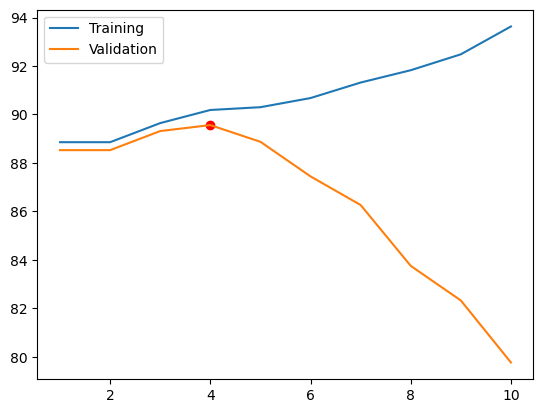

In [35]:
##### Your tests here #####
from hw2 import depth_pruning
depth_training_acc, depth_validation_acc = depth_pruning(X_train, X_validation)

plt.plot(range(1, 11), depth_training_acc, label='Training')
plt.plot(range(1, 11), depth_validation_acc, label='Validation')
plt.scatter(np.argmax(depth_validation_acc)+1, max(depth_validation_acc), c='r')
plt.legend();

## 6. $\chi^2$ pruning (10 points)

Now, we wish to prune the decision tree using the $\chi^2$ (chi-squared) test.

Implement the function `chi_pruning` in `hw2.py`.

This function should construct trees while pruning nodes using P-value cut-off values in the range `[1, 0.5, 0.25, 0.1, 0.05, 0.0001]` (where 1 indicates no pruning). It then calculates and returns the training and validation accuracy of these trees. Note that you might need to modify methods in the `DecisionNode` and/or `DecisionTree` classes.

In order to debug your code, plot the training and validation accuracy as a function of the tuple (P-value, tree-depth) and verify that your results make sense. The model with highest validation accuracy is marked in red.



In [36]:
from hw2 import chi_pruning

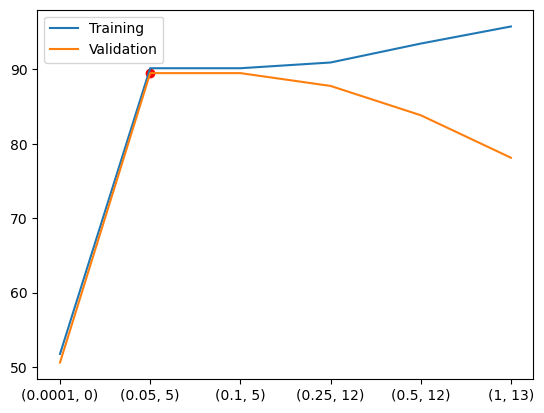

In [37]:
##### Your tests here #####

chi_training_acc, chi_validation_acc, depth = chi_pruning(X_train, X_validation)

chi_depth_tuple = [str((x, y)) for x, y in zip([1, 0.5, 0.25, 0.1, 0.05, 0.0001], depth)][::-1]
plt.plot(chi_depth_tuple, chi_training_acc[::-1], label='Training')
plt.plot(chi_depth_tuple, chi_validation_acc[::-1], label='Validation')
plt.scatter(chi_depth_tuple[np.argmax(chi_validation_acc[::-1])], max(chi_validation_acc), c='r')
plt.legend();

Now, modify the code below to construct the two best trees based on the two pruning approaches.

In [38]:
# Tree with highest validation accuracy based on depth pruning
tree_max_depth = DecisionTree(data=X_train, impurity_func=calc_entropy, max_depth=4, gain_ratio=True)
tree_max_depth.build_tree()
# Tree with highest validation accuracy based on chi-squared pruning
tree_chi = DecisionTree(data=X_train, impurity_func=calc_entropy, chi=0.05, gain_ratio=True)
tree_chi.build_tree()

## 7. Selecting Smallest Tree (4 points) 

Of the two trees above, we wish to choose the one with fewer nodes. Implement the function `count_nodes` in `hw2.py`. This function counts the number of nodes in a subtree rooted by a given `DecisionNode` object (including that node).

In [39]:
from hw2 import count_nodes

Uncomment the two lines of code below to print the sizes of the two trees you constructed above.

In [40]:
##### Your tests here #####
print(count_nodes(tree_max_depth.root))
print(count_nodes(tree_chi.root))


208
45


## 8. Print the tree

We provided you with a function that should print your tree for your own debugging purposes. 

This code prints:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
       [X5=a, leaf]: [{1.0: 5}]
       [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```

In [41]:
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    if node.terminal == False:
        if node.depth == 0:
            print('[ROOT, feature=X{}, importance={:.3f}]'.format(node.feature, node.feature_importance))
        else:
            print('{}[X{}={}, feature=X{}, importance={:.3f}], Depth: {}'.format(depth*'  ', parent_feature, 
                                                                             feature_val, node.feature, 
                                                                             node.feature_importance, node.depth))
        for i, child in enumerate(node.children):
            print_tree(child, depth+1, node.feature, node.children_values[i])
    else:
        classes_count = {}
        labels, counts = np.unique(node.data[:, -1], return_counts=True)
        for l, c in zip(labels, counts):
            classes_count[l] = c
        print('{}[X{}={}, leaf]: [{}], Depth: {}'.format(depth*'  ', parent_feature, feature_val,
                                                         classes_count, node.depth))

In [42]:
print_tree(tree_entropy_gain_ratio.root)

[ROOT, feature=X4, importance=0.216]
  [X4=a, feature=X2, importance=0.000], Depth: 1
    [X2=n, feature=X8, importance=0.000], Depth: 2
      [X8=n, feature=X19, importance=0.001], Depth: 3
        [X19=s, feature=X0, importance=0.000], Depth: 4
          [X0=f, feature=X18, importance=0.000], Depth: 5
            [X18=k, leaf]: [{'e': np.int64(1)}], Depth: 6
            [X18=n, leaf]: [{'e': np.int64(1), 'p': np.int64(1)}], Depth: 6
          [X0=x, leaf]: [{'e': np.int64(2), 'p': np.int64(2)}], Depth: 5
        [X19=y, leaf]: [{'e': np.int64(8)}], Depth: 4
      [X8=p, feature=X0, importance=0.000], Depth: 3
        [X0=f, feature=X19, importance=0.000], Depth: 4
          [X19=s, leaf]: [{'e': np.int64(2)}], Depth: 5
          [X19=y, leaf]: [{'p': np.int64(1)}], Depth: 5
        [X0=x, leaf]: [{'e': np.int64(7)}], Depth: 4
      [X8=w, feature=X18, importance=0.000], Depth: 3
        [X18=k, feature=X0, importance=0.000], Depth: 4
          [X0=f, leaf]: [{'e': np.int64(3)}], Dept